In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import xarray as xr
from xgcm import Grid
import numpy as np

In [3]:
import matplotlib.pyplot as plt

In [4]:
import regionate as reg
import sectionate as sec

In [5]:
import pickle
BasinsFile = "/work/hfd/datasets/regionate/pickled_regions/PJ2010_region_gridded_CM4p125_moc"
with open(BasinsFile, 'rb') as pickle_file:
    region = pickle.load(pickle_file)

In [6]:
sg = xr.open_dataset("/archive/Raphael.Dussin/datasets/OM4p125/mosaic_c192_om4p125_bedmachine_v20210310_hydrographyKDunne20210614_unpacked/ocean_hgrid.nc")
zdiag_path = "/archive/Raphael.Dussin/FMS2019.01.03_devgfdl_20210706/CM4_piControl_c192_OM4p125_v7/gfdl.ncrc4-intel18-prod-openmp/pp/ocean_annual_rho2/"
og = xr.open_dataset(f"{zdiag_path}ocean_annual_rho2.static.nc")
og = og.assign_coords({'geolon'  : xr.DataArray(sg['x'][1::2,1::2].data, dims=["yh", "xh"]),
                                       'geolat'  : xr.DataArray(sg['y'][1::2,1::2].data, dims=["yh", "xh"]),
                                       'geolon_u': xr.DataArray(sg['x'][1::2,0::2].data, dims=["yh", "xq"]),
                                       'geolat_u': xr.DataArray(sg['y'][1::2,0::2].data, dims=["yh", "xq"]),
                                       'geolon_v': xr.DataArray(sg['x'][0::2,1::2].data, dims=["yq", "xh"]),
                                       'geolat_v': xr.DataArray(sg['y'][0::2,1::2].data, dims=["yq", "xh"]),
                                       'geolon_c': xr.DataArray(sg['x'][0::2,0::2].data, dims=["yq", "xq"]),
                                       'geolat_c': xr.DataArray(sg['y'][0::2,0::2].data, dims=["yq", "xq"])})
symmetric = og.geolon.shape == og.geolon_c.shape

rho0 = 1035.

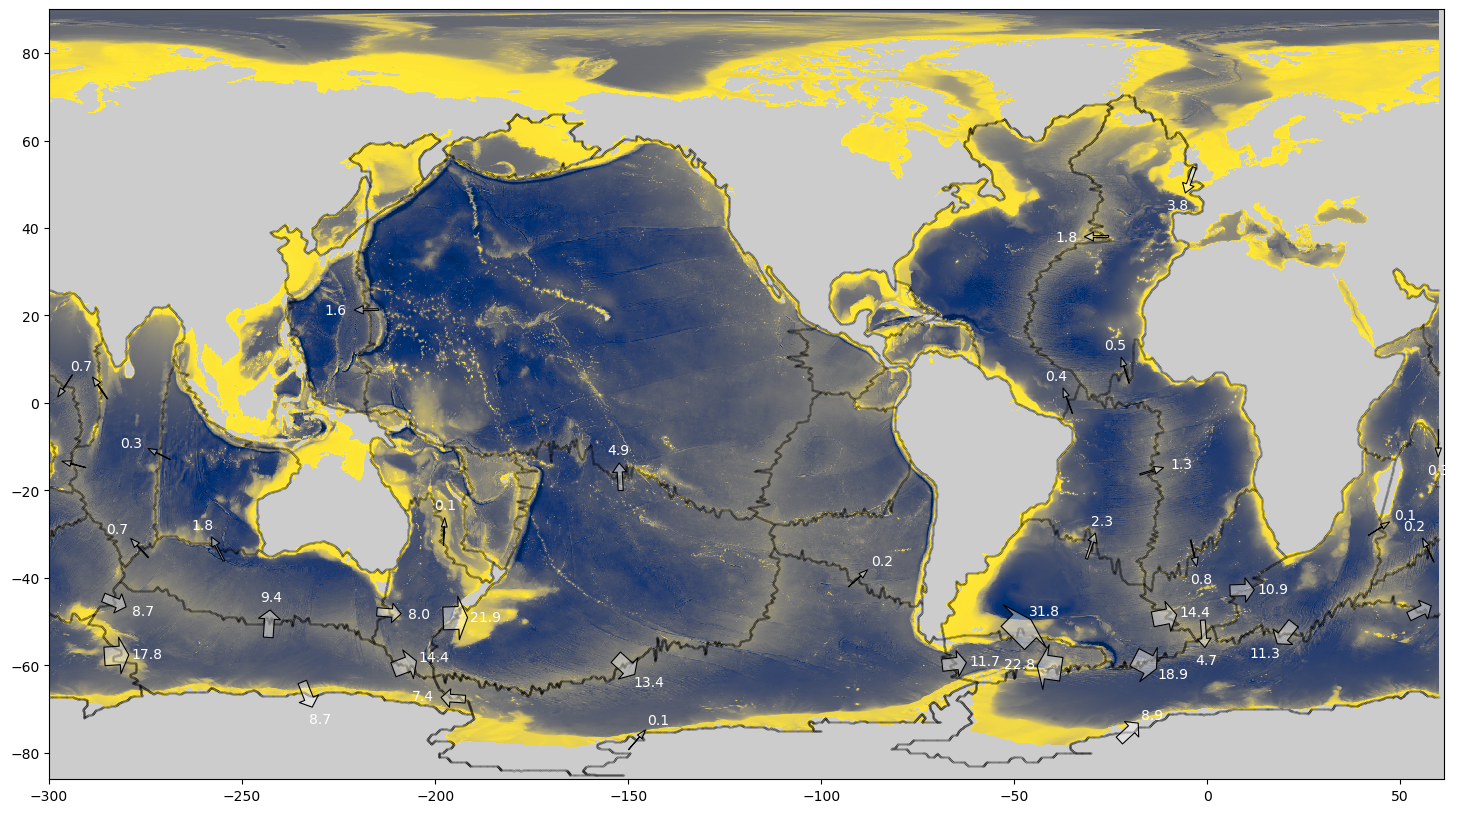

In [191]:
cmap = plt.get_cmap("cividis_r").copy()
cmap.set_bad((0.8, 0.8, 0.8))

fig, ax = plt.subplots(1,1,figsize=(18, 10))
ax.set_facecolor((0.8, 0.8, 0.8))
plt.pcolormesh(
    og['geolon_c'], og['geolat_c'],
    og['deptho'],
    cmap=cmap,
)

for b in region.Basins.values():
    plt.plot(b.lons, b.lats, "k.", markersize=0.25, alpha=0.25)


    for oname, o in region.overlaps.items():
        if b.name not in oname: continue
        if oname[0] == b.name:
            other = region.Basins[oname[1]]
        else:
            continue

        Ψexchange = np.round(b.psi_exchange[oname].isel(rho2_l=-1).values, 1)
        if Ψexchange == 0.: continue

        oidx = [oooo for ooo in o[b.name].values() for oooo in ooo]
        lon_ex = b.lons_uv[oidx[len(oidx)//2]]
        lat_ex = b.lats_uv[oidx[len(oidx)//2]]
        
        oidx_other = [oooo for ooo in o[other.name].values() for oooo in ooo]
        lon_ex_other = other.lons_uv[oidx_other[len(oidx_other)//2]]
        lat_ex_other = other.lats_uv[oidx_other[len(oidx_other)//2]]
        
        b.lon_av = reg.lon_mod(b.mask.geolon.where(b.mask), lon_ex).mean()
        b.lat_av = b.mask.geolat.where(b.mask).mean()

        other.lon_av = reg.lon_mod(other.mask.geolon.where(other.mask), lon_ex_other).mean()
        other.lat_av = other.mask.geolat.where(other.mask).mean()
        
        if np.any(np.abs(np.diff(reg.lon_mod(b.lons, lon_ex)))>180):
            b.lon_av = lon_ex
        elif np.any(np.abs(np.diff(reg.lon_mod(other.lons, lon_ex_other)))>180):
            other.lon_av = lon_ex_other
            
        if b.name == '34':
            b.lat_av = -85
        elif other.name == '34':
            other.lat_av = -85
            
        if b.name == '35':
            b.lat_av = 85
        elif other.name == '35':
            other.lat_av = 85
            
        δlon = b.lon_av - other.lon_av
        δlat = b.lat_av - other.lat_av
        scale = 3.5/np.sqrt(δlon**2 + δlat**2)
        δlon *= scale
        δlat *= scale

        s = np.sign(Ψexchange)
        xy_end = (lon_ex + s*δlon, lat_ex + s*δlat)
        xy_start = (lon_ex - s*δlon, lat_ex - s*δlat)
        xytext = (lon_ex + 2.25*s*δlon, lat_ex + 1.75*s*δlat)

        arrowprops = dict(shrink=0.05, width=0.75*np.abs(Ψexchange), headlength=6.5, headwidth=4+1.25*np.abs(Ψexchange),
                          edgecolor='black', facecolor=(1.,1.,1.,0.4), linewidth=0.8)

        plt.annotate("", xy_end, xytext=xy_start, va="center", ha="center", arrowprops=arrowprops)
        plt.annotate(f"{str(np.abs(Ψexchange))}", xytext, xytext=xytext, va="center", ha="center", color="w")

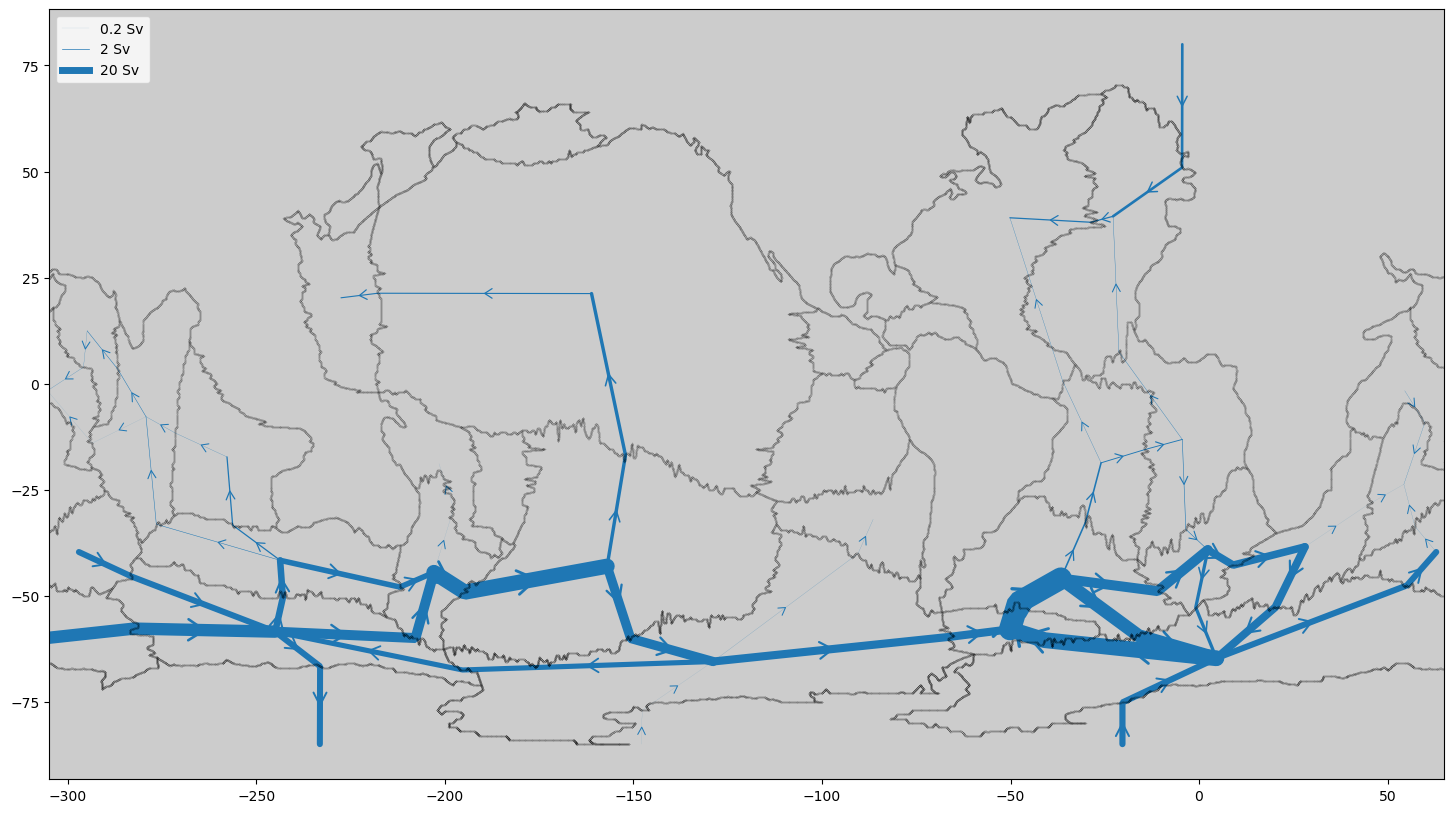

In [193]:
cmap = plt.get_cmap("cividis_r").copy()
cmap.set_bad((0.8, 0.8, 0.8))

fig, ax = plt.subplots(1,1,figsize=(18, 10))
ax.set_facecolor((0.8, 0.8, 0.8))

for b in region.Basins.values():
    for oname, o in region.overlaps.items():
        if b.name not in oname: continue
        if oname[0] == b.name:
            other = region.Basins[oname[1]]
        else:
            continue

        Ψexchange = np.round(b.psi_exchange[oname].isel(rho2_l=-1).values, 1)
        if np.abs(Ψexchange) == 0.: continue

        oidx = [oooo for ooo in o[b.name].values() for oooo in ooo]
        lon_ex = b.lons_uv[oidx[len(oidx)//2]]
        lat_ex = b.lats_uv[oidx[len(oidx)//2]]
        
        oidx_other = [oooo for ooo in o[other.name].values() for oooo in ooo]
        lon_ex_other = other.lons_uv[oidx_other[len(oidx_other)//2]]
        lat_ex_other = other.lats_uv[oidx_other[len(oidx_other)//2]]
        
        b.lon_av = reg.lon_mod(b.mask.geolon.where(b.mask), lon_ex).mean().values
        b.lat_av = b.mask.geolat.where(b.mask).mean().values

        other.lon_av = reg.lon_mod(other.mask.geolon.where(other.mask), lon_ex_other).mean().values
        other.lat_av = other.mask.geolat.where(other.mask).mean().values
        
        if np.any(np.abs(np.diff(reg.lon_mod(b.lons, lon_ex)))>180):
            b.lon_av = lon_ex
        elif np.any(np.abs(np.diff(reg.lon_mod(other.lons, lon_ex_other)))>180):
            other.lon_av = lon_ex_other
            
        if b.name == '34':
            b.lat_av = -85
        elif other.name == '34':
            other.lat_av = -85
            
        if b.name == '35':
            b.lat_av = 80
        elif other.name == '35':
            other.lat_av = 80

        δlon = b.lon_av - other.lon_av
        δlat = b.lat_av - other.lat_av
        δ = 3.5
        scale = δ/np.sqrt(δlon**2 + δlat**2)
        δlon *= scale
        δlat *= scale

        s = np.sign(Ψexchange)
        xy_end = (lon_ex + s*δlon, lat_ex + s*δlat)
        xy_start = (lon_ex - s*δlon, lat_ex - s*δlat)
        xytext = (lon_ex + 2.25*s*δlon, lat_ex + 1.75*s*δlat)

        scale_bar = 0.5
        plt.plot([b.lon_av, lon_ex, other.lon_av], [b.lat_av, lat_ex, other.lat_av], lw=np.abs(Ψexchange)*scale_bar, color="C0", solid_capstyle="round", solid_joinstyle="bevel")
        
        δlon1, δlat1 = lon_ex-b.lon_av, lat_ex-b.lat_av
        lon1, lat1 = b.lon_av+δlon1/2., b.lat_av+δlat1/2.
        
        scale_arrows = np.abs(Ψexchange)*scale_bar/3+2.
        lw_arrows = np.sqrt(np.abs(Ψexchange)*scale_bar/3+0.5)
        
        ϕ = np.deg2rad(30.)
        θ = np.arctan2(-s*δlat1, -s*δlon1)
        plt.plot(
            lon1+scale_arrows*np.array([-np.cos(θ)*np.cos(ϕ) - np.sin(θ)*np.sin(ϕ), 0, -np.cos(θ)*np.cos(ϕ) + np.sin(θ)*np.sin(ϕ)]),
            lat1+scale_arrows*np.array([-np.sin(θ)*np.cos(ϕ) + np.cos(θ)*np.sin(ϕ), 0, -np.sin(θ)*np.cos(ϕ) - np.cos(θ)*np.sin(ϕ)]),
            color="C0", lw=lw_arrows, solid_capstyle="round", solid_joinstyle="round"
        )
        
        δlon2, δlat2 = other.lon_av-lon_ex, other.lat_av-lat_ex
        lon2, lat2 = lon_ex+δlon2/2., lat_ex+δlat2/2.
        
        ϕ = np.deg2rad(30.)
        θ = np.arctan2(-s*δlat2, -s*δlon2)
        plt.plot(
            lon2+scale_arrows*np.array([-np.cos(θ)*np.cos(ϕ) - np.sin(θ)*np.sin(ϕ), 0, -np.cos(θ)*np.cos(ϕ) + np.sin(θ)*np.sin(ϕ)]),
            lat2+scale_arrows*np.array([-np.sin(θ)*np.cos(ϕ) + np.cos(θ)*np.sin(ϕ), 0, -np.sin(θ)*np.cos(ϕ) - np.cos(θ)*np.sin(ϕ)]),
            color="C0", lw=lw_arrows, solid_capstyle="round", solid_joinstyle="round"
        )
        
        plt.xlim(-305, 65)
        
for b in region.Basins.values():
    plt.plot(b.lons, b.lats, "k.", markersize=0.25, alpha=0.2)
    plt.plot(b.lons+360., b.lats, "k.", markersize=0.25, alpha=0.2)
    plt.plot(b.lons-360., b.lats, "k.", markersize=0.25, alpha=0.2)
        
plt.plot([], [], "C0-", lw=0.1*scale_bar, label="0.2 Sv")
plt.plot([], [], "C0-", lw=1*scale_bar, label="2 Sv")
plt.plot([], [], "C0-", lw=10*scale_bar, label="20 Sv")
plt.legend(loc="upper left")

In [206]:
def get_aspect(ax=None):
    if ax is None:
        ax = plt.gca()
    fig = ax.figure

    ll, ur = ax.get_position() * fig.get_size_inches()
    width, height = ur - ll
    axes_ratio = height / width
    aspect = axes_ratio / ax.get_data_ratio()

    return aspect

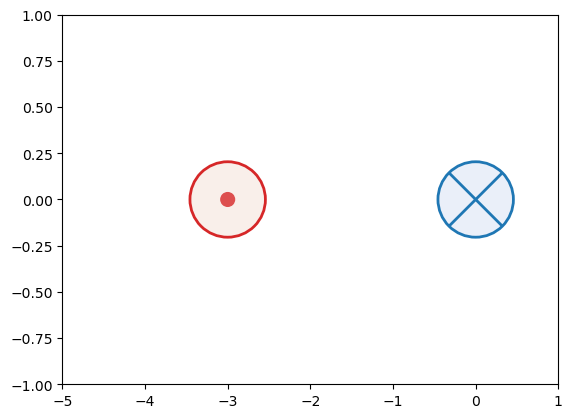

In [289]:
from matplotlib.patches import Ellipse


ax=plt.subplot()
ax.set_xlim(-5, 1)
ax.set_ylim(-1, 1)

aspect = get_aspect(ax)

scale = np.sqrt(1+aspect**2)

ellipse = Ellipse((0, 0), aspect/scale, 1/scale, angle=0, alpha=0.1, facecolor=(0.2, 0.4, 0.8))
ax.add_artist(ellipse)
plt.plot([-aspect/scale/2*np.cos(np.pi/4), aspect/scale/2*np.cos(np.pi/4)], [1/scale/2*np.sin(np.pi/4),-1/scale/2*np.sin(np.pi/4)], solid_capstyle="butt", color="C0",linewidth=2.)
plt.plot([-aspect/scale/2*np.cos(np.pi/4), aspect/scale/2*np.cos(np.pi/4)], [-1/scale/2*np.sin(np.pi/4), 1/scale/2*np.sin(np.pi/4)], solid_capstyle="butt", color="C0",linewidth=2.)
ellipse = Ellipse((0, 0), aspect/scale, 1/scale, angle=0, linewidth=2., facecolor=(1., 1., 1., 0.), edgecolor="C0")
ax.add_artist(ellipse)

ellipse = Ellipse((-3, 0), aspect/scale, 1/scale, angle=0, alpha=0.1, facecolor=(0.8, 0.4, 0.2))
ax.add_artist(ellipse)
ellipse = Ellipse((-3, 0), 0.2*aspect/scale, 0.2*1/scale, angle=0, alpha=0.8, facecolor="C3")
ax.add_artist(ellipse)
ellipse = Ellipse((-3, 0), aspect/scale, 1/scale, angle=0, facecolor=(1., 1., 1., 0.), edgecolor="C3", linewidth=2.)
ax.add_artist(ellipse)

In [195]:
b = region.Basins['24']

In [198]:
b.psi_exchange[('23','24')].isel(rho2_l=-1)

<xarray.DataArray 'conv_mass_transport' ()>
array(2.3117292, dtype=float32)
Coordinates:
    rho2_l   float64 1.039e+03
    time     object 0350-07-02 12:00:00